In [56]:
import os
import pandas as pd
import numpy as np
import tensorflow as tf
import seaborn as sns
import sklearn
import matplotlib.pyplot as plt
from IPython.display import Image

# We will generate a lot of figures in some cells, disable warnings
plt.rcParams.update({'figure.max_open_warning': 0})

In [2]:
df = pd.read_csv('height_v_weight.csv')
df.describe()

,Height,Weight
count,150.000000,150.000000
mean,68.881589,185.590780
std,2.508824,18.911973
min,62.706990,149.173566
25%,67.255252,172.021658
50%,68.727093,183.869431
75%,70.794784,198.168729
max,75.205974,241.893563


In [3]:
def calc_mean_sq_error(df, slope, intercept):
    """
    Calculates mean-squared-error (MSE) of the line as a predictor of y-values
    """
    xs, ys = df['Height'].values, df['Weight'].values
    diffs = (slope * xs + intercept) - ys
    mse = np.mean(diffs**2) 
    return mse
    
    
def draw_scatter(df, slope=None, intercept=None, ax=None):
    if ax is None:
        _,ax = plt.subplots(figsize=(4,4))
        
    sns.scatterplot(df['Height'], df['Weight'], ax=ax, label='Sample Points')
    ax.set_xlabel('Height (inches)')
    ax.set_ylabel('Weight (lbs)')
    ax.set_title('Male Height vs. Weight Sample')
    
    # For this exercise we're going to hardcode various parameters for simplicity
    x0,x1 = 60, 78
    y0,y1 = 130, 260
    ax.set_xlim(x0, x1)
    ax.set_ylim(y0, y1)
    
    if slope is not None and intercept is not None:
        pred_y0, pred_y1 = (slope*x0 + intercept, slope*x1 + intercept)
        ax.plot([x0, x1], [pred_y0, pred_y1], 'r-.', label='Fitted Line')
        mse = calc_mean_sq_error(df, slope, intercept)
        ax.set_title(f'Height vs. Weight / MSE = {mse:.1f}')
        
    ax.legend(loc='upper left')
    return ax

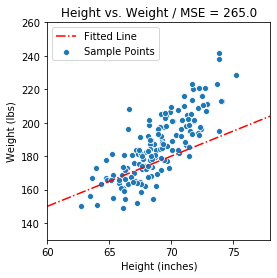

In [4]:
# Test drawing method
draw_scatter(df, slope=3, intercept = -30)

In [ ]:
###

y = 6.04*x + -230.53, with mse=127.1


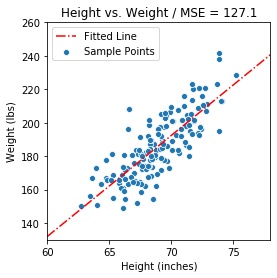

In [7]:
# Let's find the analytical solution using sklearn
from sklearn.linear_model import LinearRegression
lin_reg = LinearRegression()
lin_reg.fit(df['Height'].values.reshape([-1, 1]), df['Weight'].values)

# Let's look at the optimal model parameters and its optimal MSE loss
true_slope, true_intercept = lin_reg.coef_[0], lin_reg.intercept_
min_mse = calc_mean_sq_error(df, true_slope, true_intercept)
print(f'y = {true_slope:.2f}*x + {true_intercept:.2f}, with mse={min_mse:.1f}')

_ = draw_scatter(df, slope=true_slope, intercept=true_intercept)

## Using Tensorflow and Gradient Descent

For such a simple problem with an analytical solution, we don't need to use gradient descent.  But the goal here is to introduce Tensorflow's auto differentiation feature on a simple problem to get a feel for the its mechanics without complexity

In [76]:
def tf_calc_mse(Xtensor, Ytensor, slope, intercept):
    """
    This method is basically identical to calc_mse() from before, but we
    need to use only operations defined on tensors and tf.* methods.
    """
    predictions = tf.add(tf.multiply(slope, Xtensor), intercept)
    errors = tf.subtract(predictions, Ytensor)
    mse = tf.reduce_sum(tf.square(errors))
    return mse
    
# The following method is identical, leveraging the operator overloading.
# 
def tf_calc_mse(Xtensor, Ytensor, slope, intercept):
    predictions = slope * Xtensor + intercept
    errors = predictions - Ytensor
    mse = tf.reduce_sum(errors**2)
    return mse

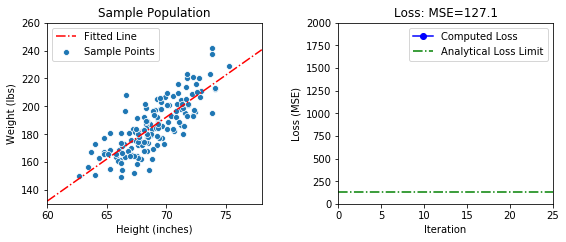

In [43]:
def draw_linreg_progress(df, slope, intercept, mse_hist, min_mse, file_out=None):
    fig, axs = plt.subplots(1, 2, figsize=(8.5,4))
    draw_scatter(df, slope, intercept, ax=axs[0])
    
    # Draw loss-chart.  Hardcode a few more parameters for simplicity
    xmin, xmax = 0, 25
    ymin, ymax = 0, 2000
    axs[1].plot(range(len(mse_hist)), mse_hist, 'b-', marker='o', label='Computed Loss')
    axs[1].plot([xmin, xmax], [min_mse, min_mse], 'g-.', label='Analytical Loss Limit')
    axs[1].set_xlim(xmin, xmax)
    axs[1].set_ylim(ymin, ymax)
    axs[1].set_xlabel('Iteration')
    axs[1].set_ylabel('Loss (MSE)')
    axs[1].legend(loc='upper right')
    
    # Update the axis titles
    mse = calc_mean_sq_error(df, slope, intercept) if len(mse_hist)==0 else mse_hist[-1]
    axs[0].set_title('Sample Population')
    axs[1].set_title(f'Loss: MSE={mse:.1f}')
    plt.tight_layout(3.0)
    
    if file_out:
        fig.savefig(file_out)
        
    return fig, axs
    
_ = draw_linreg_progress(df, true_slope, true_intercept, [], min_mse)

In [44]:
def run_gradient_descent(df, init_slope, init_icept, n_iter=20, learning_rate=2e-5, dir_name=None):
    """
    Provide initial estimate of slope and intercept, gradient descent will fine-tune
    it and provide a near-optimal solution
    """
    
    # X- and Y-values don't need to be tensors, since they are static.
    Xs, Ys = df['Height'].values, df['Weight'].values
    
    # Only need to convert variables which will be part of gradient calcs
    tf_slope = tf.Variable(init_slope, dtype='float32') 
    tf_icept = tf.Variable(init_icept, dtype='float32') 
    
    # Use this to accumulate loss values after each iteration
    loss_hist = []
    
    
    for i in range(n_iter):
        with tf.GradientTape() as tape:
            tape.watch(tf_slope)
            tape.watch(tf_icept)

            predictions = tf_slope * Xs + tf_icept
            errors = predictions - Ys
            loss = tf.reduce_mean(errors**2)

        #########################################################################
        # Magic!  Derivative of loss value w.r.t. model parameters
        dloss_dparams = tape.gradient(loss, [tf_slope, tf_icept])
        #########################################################################

        tf_slope = tf_slope - learning_rate * dloss_dparams[0]
        tf_icept = tf_icept - learning_rate * dloss_dparams[1] * 1000.0
            
        # Aggregate and plot loss-values before doing more math 
        loss_hist.append(loss)
        if dir_name:
            os.makedirs(dir_name, exist_ok=True)
            fout = os.path.join(dir_name, f'img_{i:03d}.png')
            fig, axs = draw_linreg_progress(df, tf_slope, tf_icept, loss_hist, min_mse, file_out=fout)
        
    return tf_slope.numpy(), tf_icept.numpy()
        

### ***Let's see how well it works!***

It turns out the loss surface is a bit wilder than you would expect, and we didn't normalize our data beforehand.  While this should theoretically still work, we end up needing some super-dynamic, per-parameter learning rates to get it to work from arbitrarily chosen initial values.

To avoid over-complicating this, we will simply run it a couple times from a reasonable, visible estimate of the parameters, and let it fine-tune the answer for us.

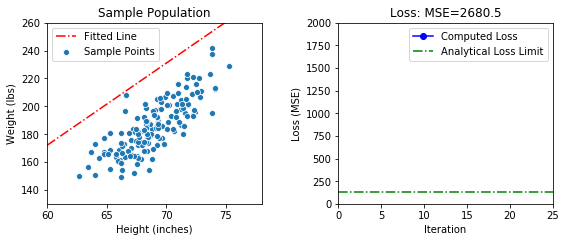

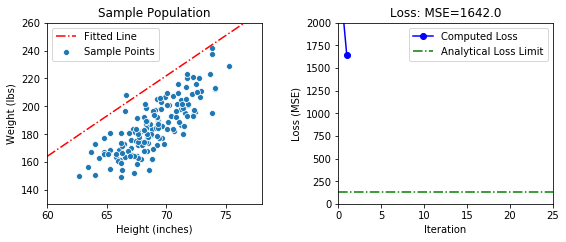

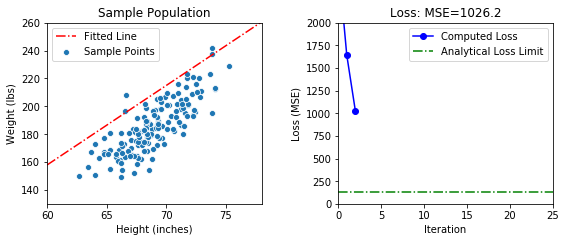

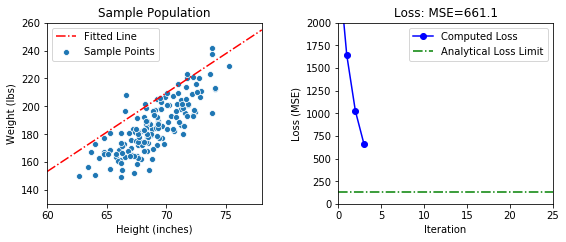

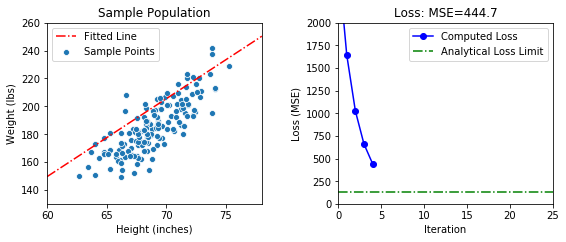

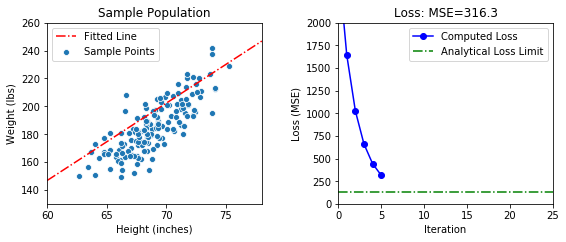

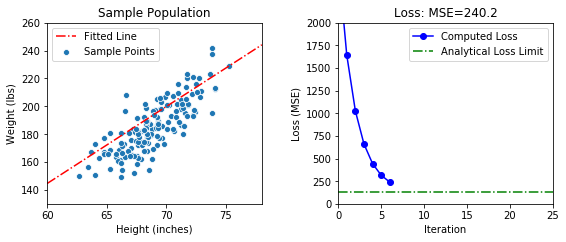

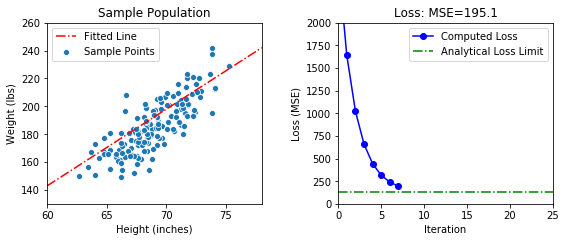

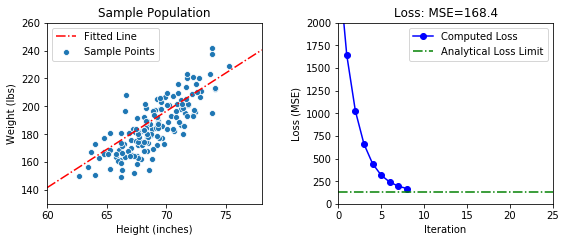

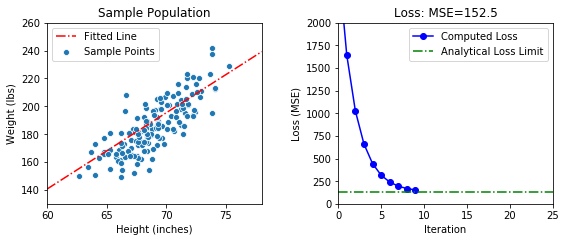

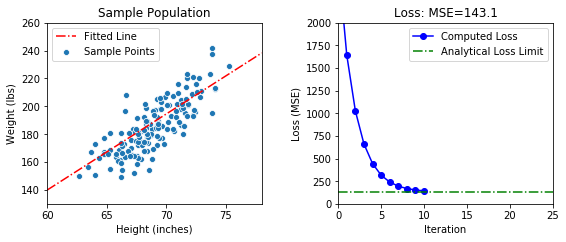

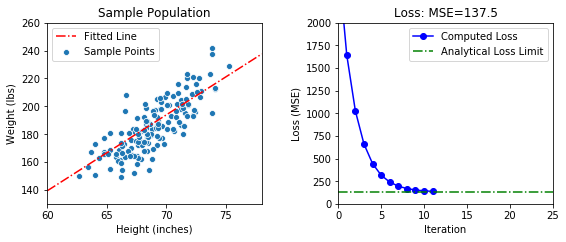

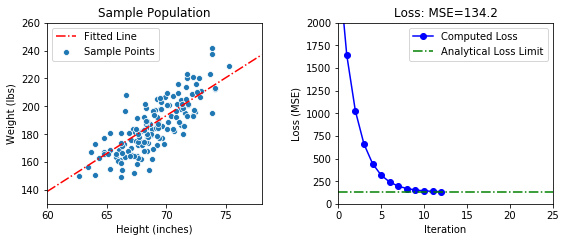

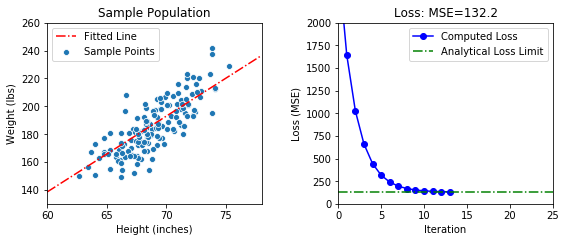

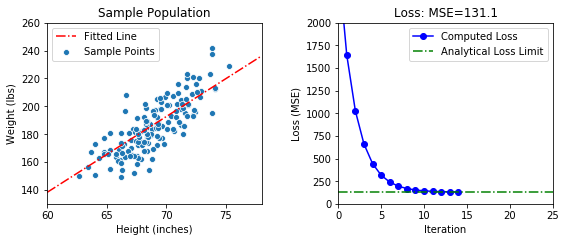

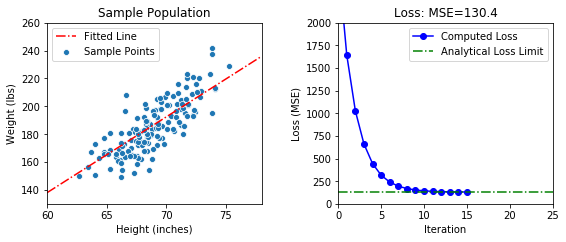

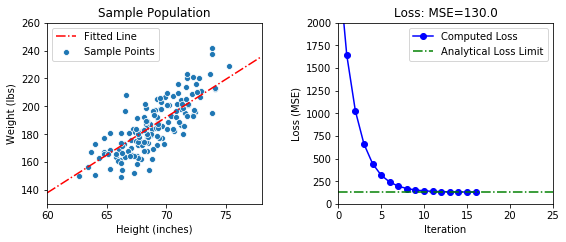

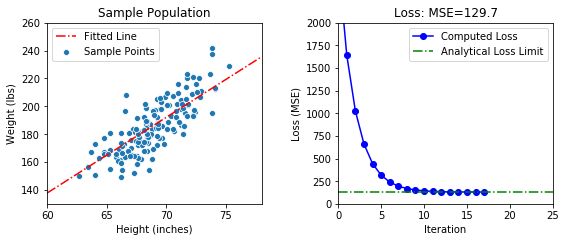

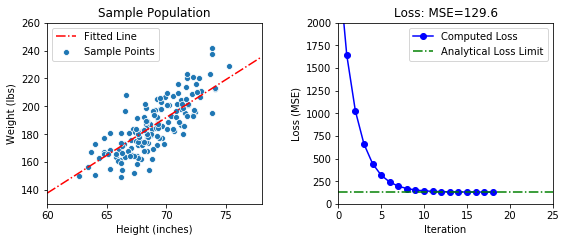

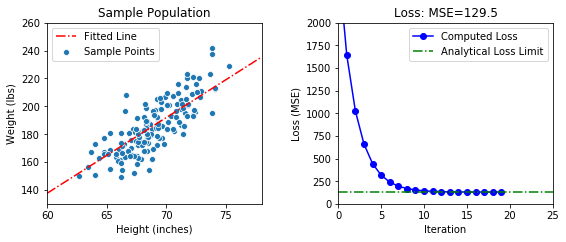

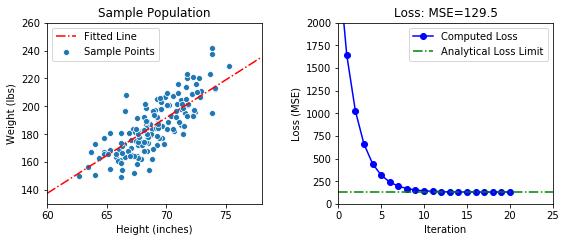

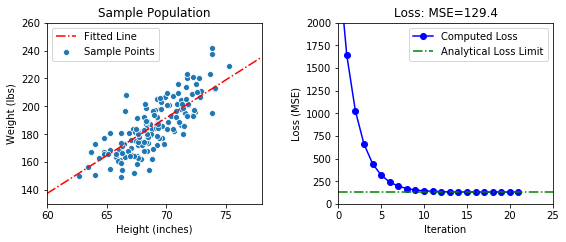

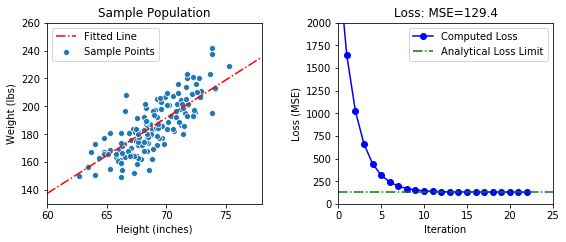

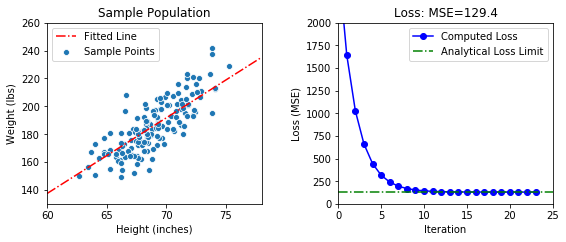

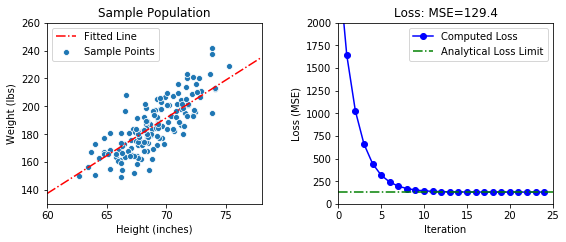

In [58]:
slope1, int1 = run_gradient_descent(df, true_slope, -180, n_iter=25, dir_name='imgs_descent_1')

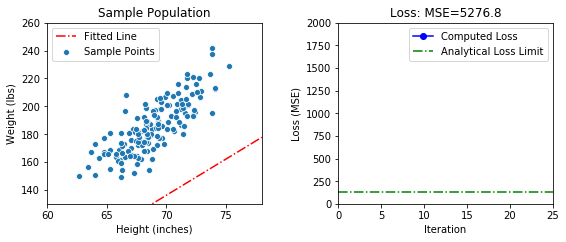

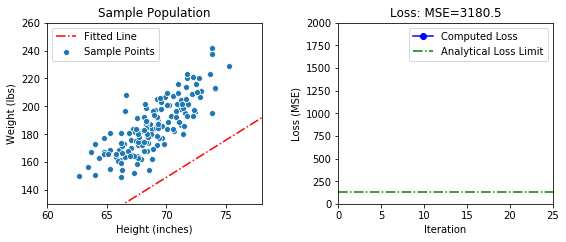

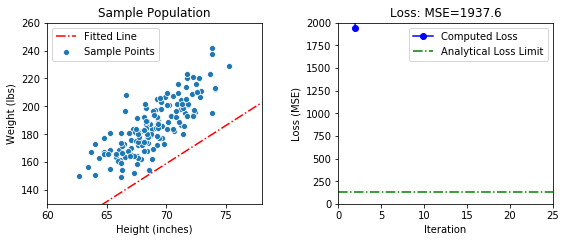

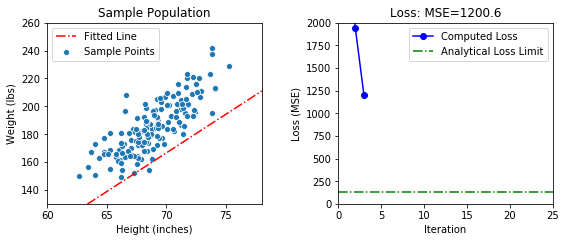

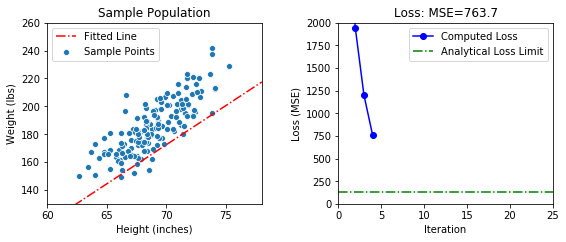

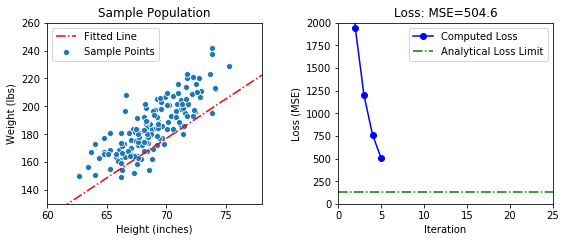

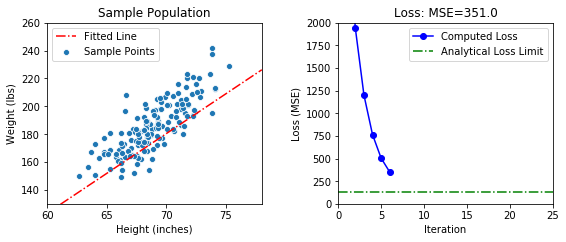

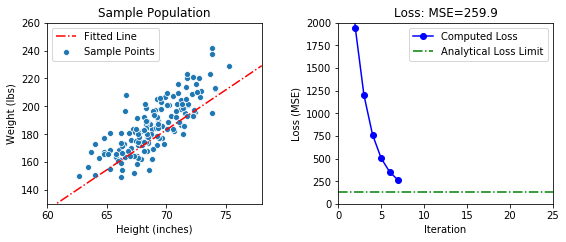

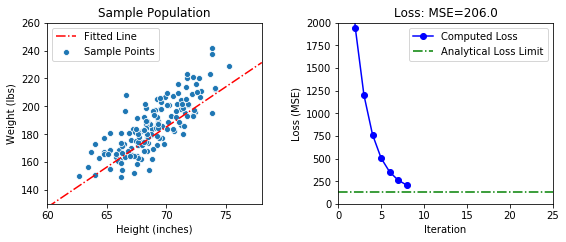

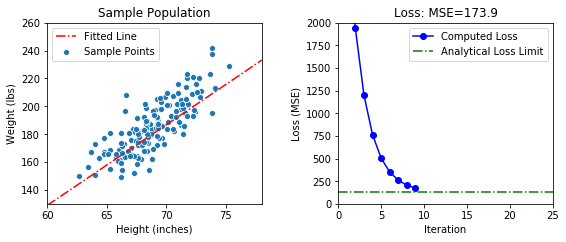

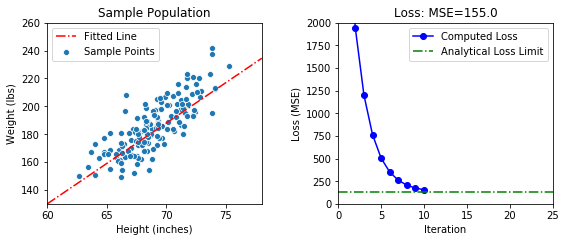

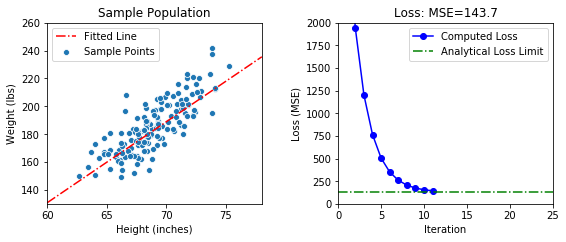

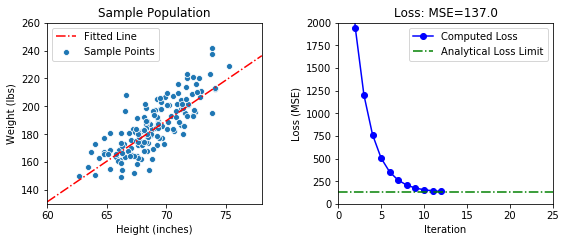

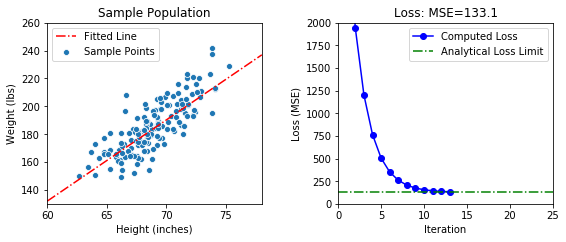

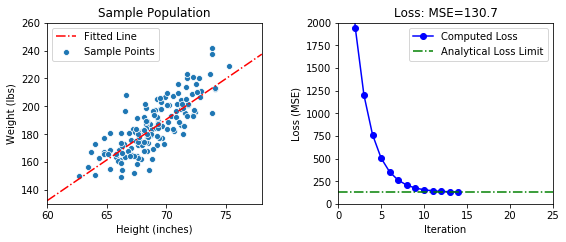

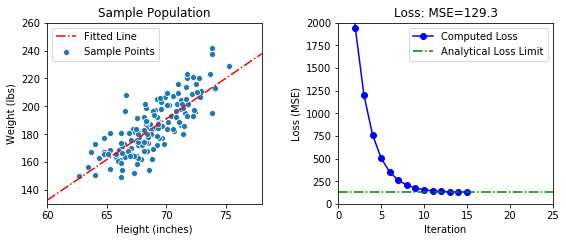

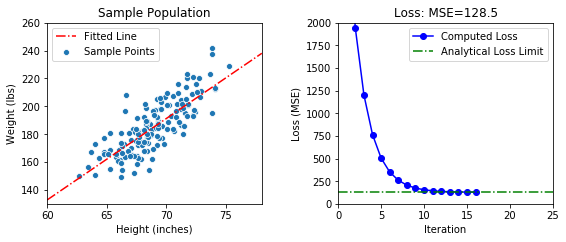

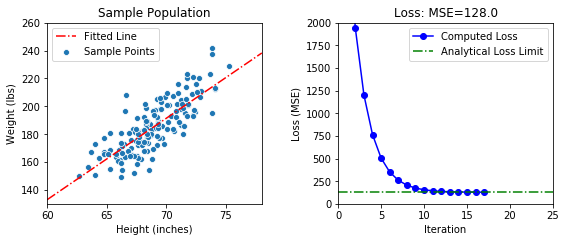

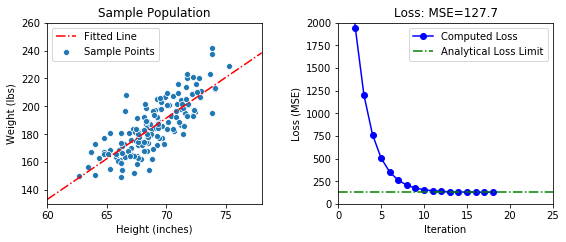

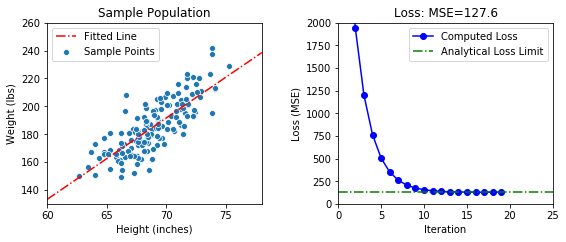

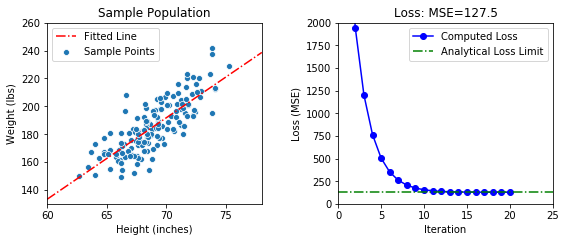

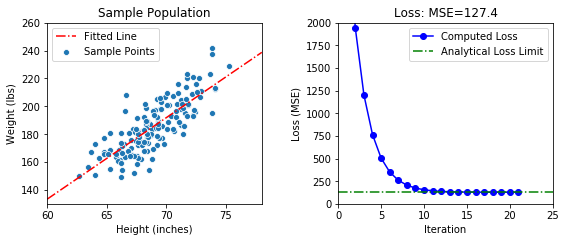

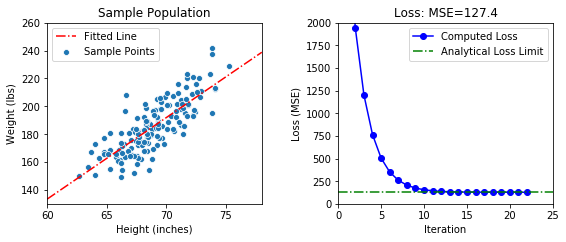

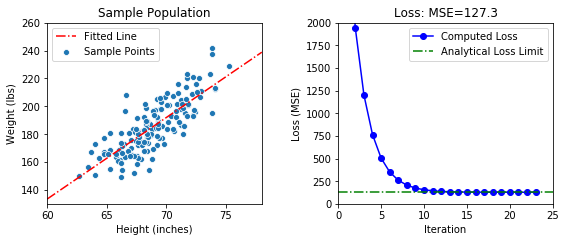

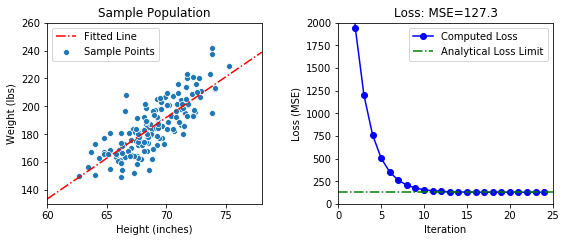

In [59]:
slope2, int2 = run_gradient_descent(df, 5.0, true_intercept, n_iter=25, dir_name='imgs_descent_2')

### Make looping .gif animations
The above methods wrote out all the figures to local directories.  Can use locally-installed imagemagick to convert them to animations.  Expect these cells to fail if you are not in Linux or you don't 

In [60]:
import subprocess
try:
    subprocess.check_output(['convert', 'imgs_descent_1/*', '-loop', '0', 'anim_1.gif'])
    subprocess.check_output(['convert', 'imgs_descent_2/*', '-loop', '0', 'anim_2.gif'])
except Exception as e:
    print(f'Failed to create .gif files.  Only works on Linux with "imagemagick" installed')
    print(f'Error: {str(e)}')
    

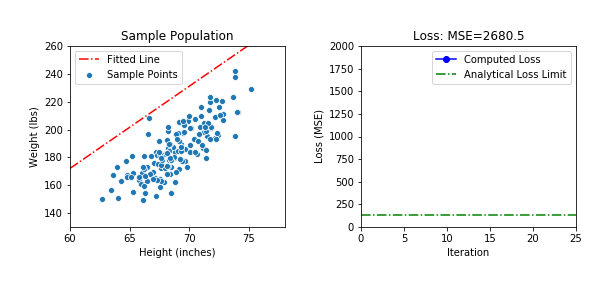

In [55]:
# Using IPython display module
Image('anim_1.gif')

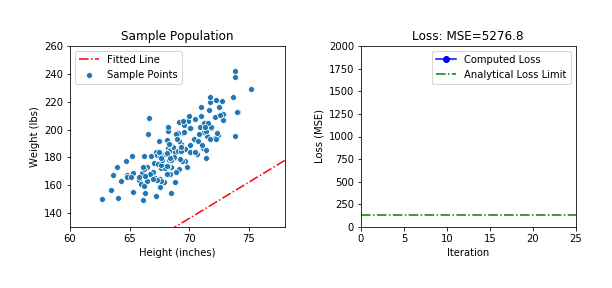

In [57]:
Image('anim_2.gif')